In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Display GPU details
        for i, gpu in enumerate(gpus):
            device_details = tf.config.experimental.get_device_details(gpu)
            print(f"GPU {i}: {device_details.get('device_name', 'Unknown GPU')}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")


GPU 0: NVIDIA GeForce RTX 4080 Laptop GPU


In [13]:
data = pd.read_csv('SniperDataset.csv')

In [14]:
X = data[['DistanceFromTarget', 'ElevationDifference', 'GunTiltX', 'GunTiltY', 
          'XDifference', 'YDifference', 'Zdifference']]
y = data['HitOrMiss']

# Use SMOTE to oversample the minority class (1s)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verify that the number of samples for both classes is now equal
print(f"Number of 1s: {sum(y_resampled == 1)}, Number of 0s: {sum(y_resampled == 0)}")

# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Number of 1s: 14275, Number of 0s: 14275


In [15]:
# Define a custom neural network from scratch using Keras
class SimpleNN(tf.keras.Model):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim)
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dense3 = tf.keras.layers.Dense(16, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)

# Initialize the model
model = SimpleNN(input_dim=X_train.shape[1])

# Compile the model (use Adam optimizer and binary crossentropy loss)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/home/abhiram/Documents/clg/ml/sniper/nn_model/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))
model.save('sniper_model.h5')  # Save model in HDF5 format

Epoch 1/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9159 - loss: 0.2232 - val_accuracy: 0.9063 - val_loss: 0.2400
Epoch 2/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9148 - loss: 0.2231 - val_accuracy: 0.9019 - val_loss: 0.2520
Epoch 3/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9119 - loss: 0.2296 - val_accuracy: 0.9051 - val_loss: 0.2444
Epoch 4/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.9136 - loss: 0.2253 - val_accuracy: 0.9060 - val_loss: 0.2412
Epoch 5/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9135 - loss: 0.2244 - val_accuracy: 0.9058 - val_loss: 0.2481
Epoch 6/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9138 - loss: 0.2265 - val_accuracy: 0.9060 - val_loss: 0.2411
Epoch 7/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9141 - loss: 0.2266 - val_accuracy: 0.9040 - val_loss: 0.2447
Epoch 8/30
714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9097 - loss: 0.2326 - val_accuracy

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9056 - loss: 0.2465
Test Accuracy: 0.9077


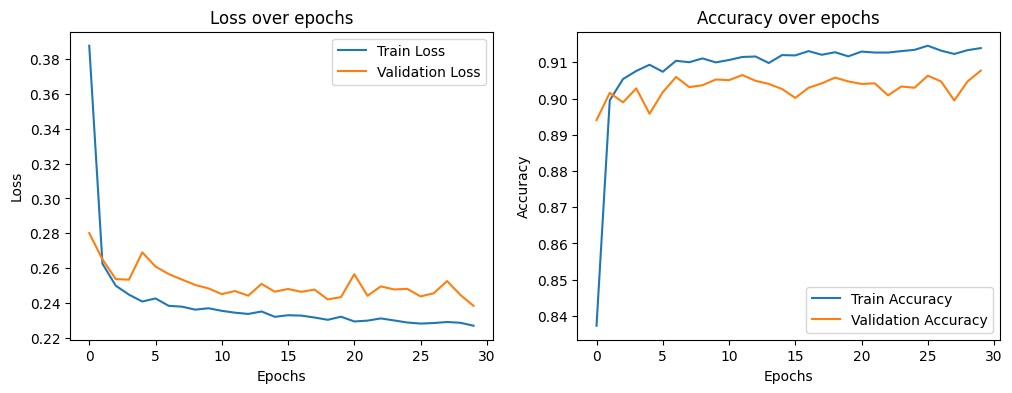

In [18]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Compare predictions with actual values
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': predicted_classes.flatten()})
print(comparison.head())


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   Actual  Predicted
0       0          0
1       1          1
2       1          1
3       0          0
4       0          0


In [21]:
# Function to preprocess the input data and make predictions
def predict_hit_or_miss(input_data):
    try:
        # Convert the input data string into a numpy array of floats
        input_values = np.array([list(map(float, input_data.split(',')))])

        # Ensure the correct number of features is passed in
        if input_values.shape[1] != X_train.shape[1]:
            raise ValueError(f"Expected {X_train.shape[1]} features, but got {input_values.shape[1]}.")

        # Normalize the input using the same scaler used during training
        input_scaled = scaler.transform(input_values)

        # Predict using the model
        prediction = model.predict(input_scaled)

        # Convert the prediction to binary class (0 = Miss, 1 = Hit)
        predicted_class = (prediction > 0.5).astype(int)

        # Print the predicted probability and class
        print(f"Predicted Probability: {prediction[0][0]:.2f}")
        print(f"Predicted Class: {'Hit' if predicted_class[0][0] == 1 else 'Miss'}")
    except Exception as e:
        print(f"Error during prediction: {e}")

# Example: You can copy-paste your input data as a comma-separated string
input_data = "51.873,1.479471,76.0825,91.10352,-1.731583,1.479471,51.82298"  # New input data as string

# Call the prediction function
predict_hit_or_miss(input_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Probability: 0.83
Predicted Class: Hit


/home/abhiram/Documents/clg/ml/sniper/nn_model/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
